In [21]:
import numpy as np
import math 
import pandas as pd
from pandas.io.json import json_normalize
import json
import sys  
sys.path.insert(0, './scripts')
from PricingModels import *

cols = ["apy","time_stretch","x_reserves","y_reserves","amount","apy_after_slippage","slippage"]
data=[]
for APY in np.arange(1, 51, 1):
    time_stretch = Element_Pricing_Model.calc_time_stretch(APY)
    days_until_maturity = 90
    t = days_until_maturity/(365*time_stretch)
    T = days_until_maturity/365
    g = .1
    y_reserves = 1
    x_reserves = Element_Pricing_Model.calc_x_reserves(APY,y_reserves,days_until_maturity,time_stretch)
    total_supply=x_reserves+y_reserves
    max_trade = Element_Pricing_Model.calc_max_trade(y_reserves+total_supply,x_reserves,t)-.0001
    for amount in np.arange(max_trade, max_trade/100, -max_trade/100):
        (without_fee_or_slippage,with_fee,without_fee,fee) = Element_Pricing_Model.calc_out_given_in(amount,y_reserves+total_supply,x_reserves,"base",g,t)
        APY_slippage = Element_Pricing_Model.apy(without_fee/amount,days_until_maturity)
        slippage = APY_slippage/APY
        data.append([APY,time_stretch,x_reserves,y_reserves,amount/max_trade,APY_slippage,slippage])
        
df = pd.DataFrame(data,columns=cols)
df

#print("reserves: " + str((x_reserves,y_reserves)))
#print("without_fee_or_slippage: " + str(without_fee_or_slippage))
#print("price: " + str(with_fee))
#print("max_trade: " + str(max_trade))
#print("check apy: " + str(Element_Pricing_Model.apy(without_fee/amount,days_until_maturity)))




,apy,time_stretch,x_reserves,y_reserves,amount,apy_after_slippage,slippage
0,1,110.93439,0.98207,1,1.00000,2.03271,2.03271
1,1,110.93439,0.98207,1,0.99000,1.99039,1.99039
2,1,110.93439,0.98207,1,0.98000,1.95938,1.95938
3,1,110.93439,0.98207,1,0.97000,1.93254,1.93254
4,1,110.93439,0.98207,1,0.96000,1.90832,1.90832
...,...,...,...,...,...,...,...
4954,50,2.21869,0.88216,1,0.06000,51.85205,1.03704
4955,50,2.21869,0.88216,1,0.05000,51.54091,1.03082
4956,50,2.21869,0.88216,1,0.04000,51.23079,1.02462
4957,50,2.21869,0.88216,1,0.03000,50.92165,1.01843


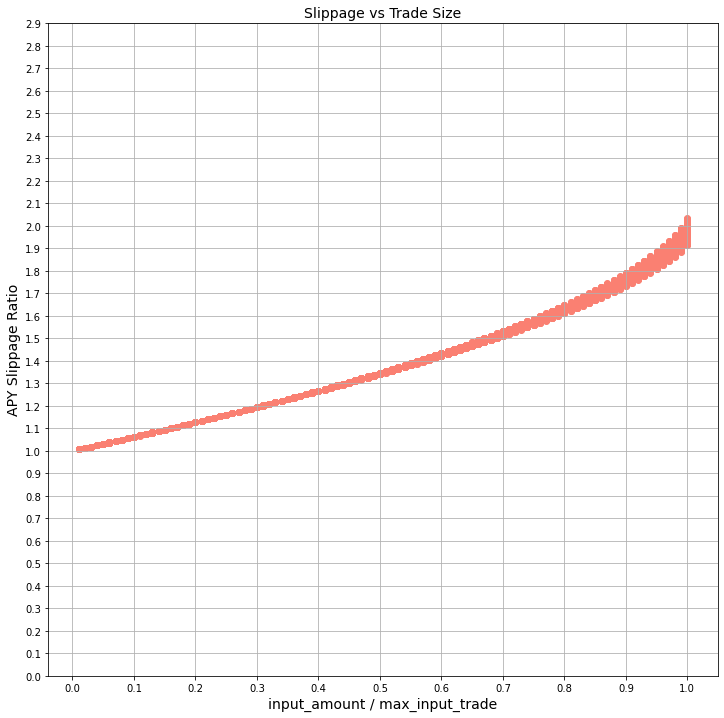

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

plt.subplots(figsize=(12,12))

df_filtered = df#[(df['amount']<=0.5)]
plt.scatter(df_filtered['amount'], df_filtered['slippage'], color='salmon',label= df_filtered['apy'].iloc[0])

plt.title('Slippage vs Trade Size', fontsize=14)
plt.xlabel('input_amount / max_input_trade', fontsize=14)
plt.ylabel('APY Slippage Ratio', fontsize=14)
plt.grid(True)
plt.yticks(np.arange(0,3, .1))
plt.xticks(np.arange(0,1.1, .1))


plt.show()

In [23]:
from scipy.optimize import curve_fit

def objective(x,a,b):
    return a*x + b

data = df.values
x = df[df['amount']<=0.5]['amount']
y = df[df['amount']<=0.5]['slippage']
# curve fit
popt, _ = curve_fit(objective, x, y)
# summarize the parameter values
a, b = popt
print('y = %.5f * x + %.5f' % (a, b))

y = 0.68583 * x + 0.99201


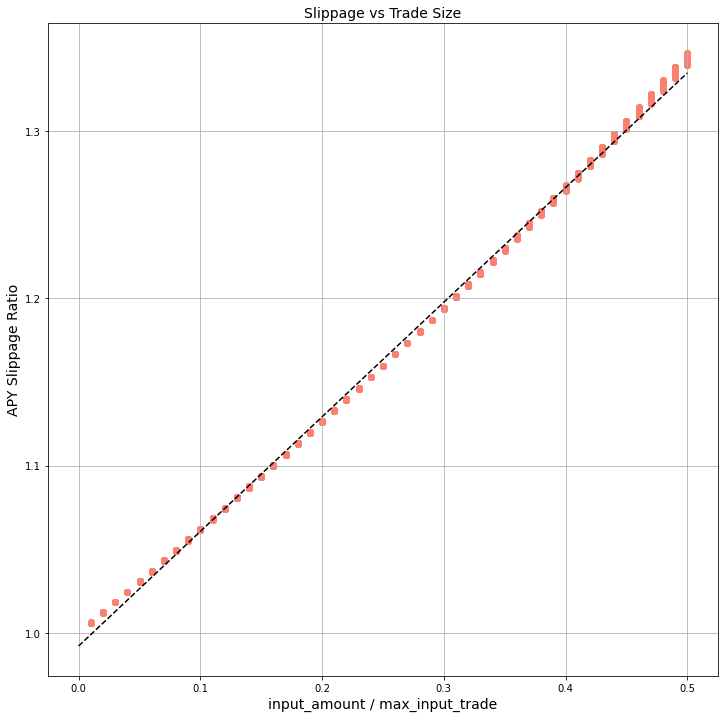

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

plt.subplots(figsize=(12,12))

df_filtered = df[(df['amount']<=0.5)]
plt.scatter(df_filtered['amount'], df_filtered['slippage'], color='salmon',label= df_filtered['apy'].iloc[0])

plt.title('Slippage vs Trade Size', fontsize=14)
plt.xlabel('input_amount / max_input_trade', fontsize=14)
plt.ylabel('APY Slippage Ratio', fontsize=14)
plt.grid(True)
plt.yticks(np.arange(0,3, .1))
plt.xticks(np.arange(0,.6, .1))

x = np.arange(0,.6,.1)
y = 0.68583 * x + 0.99201
plt.plot(x, y, '--', color="black")

plt.show()

In [26]:
APY_speculated = 30
APY_target = 40
term_length = 90
liquidity = 50
time_stretch = Element_Pricing_Model.calc_time_stretch(APY_speculated)
gas_fee = 0.0019
input_amount = .5
N= 10

t = (term_length) / (365 * time_stretch)
T = (term_length) / 365
UnitPrice = 1 - ((APY_speculated/100) * T - (APY_target/(100*N)) * T - gas_fee/input_amount)
print(UnitPrice)
APY_PT = (1-UnitPrice)/T * 100
print(APY_PT)

expenditure=input_amount-UnitPrice*input_amount+gas_fee
received = (input_amount * APY_speculated / 100) * (term_length) / 365
output_amount = (UnitPrice)*input_amount
fee = (input_amount - output_amount) * .1
output_amount = output_amount+fee
pt_apy = (1- output_amount/input_amount)/T * 100
print(pt_apy)

y_after=liquidity+input_amount
x_after=Element_Pricing_Model.calc_x_reserves(pt_apy,y_after,term_length,time_stretch)
print((x_after,y_after))
print((1-1/(pow((y_after+x_after)/x_after,t)))/T *100)
y_before=liquidity
x_before=x_after+output_amount
print((x_before,y_before))
pt_apy_before = (1-1/(pow((y_before+x_before)/x_before,t)))/T *100
print(pt_apy_before)

total_supply = x_after+y_after
k = (y_after + total_supply)**(1-t) + x_after**(1-t)
j = input_amount 
#i = x_after - pow(k-pow(y_after + total_supply + j,1-t),1/(1-t))
i = y_after + total_supply - pow(k-pow(x_after + j,1-t),1/(1-t))
print((1-(j / i))/T * 100 + APY_PT/100)
print((1-(j / i))/T * 100 + (1-1/(pow((y_after+x_after)/x_after,t)))/T)
print((1-(j / i))/T * 100 + (1-1/(pow((y_before+x_before)/x_before,t)))/T)




0.9396904109589042
24.458888888888872
22.013
(77.14319190445838, 50.5)
13.392092451855472
(77.61605258938988, 50)
13.22669590046965
22.136891773228466
22.026223808858134
22.024569843344274


In [27]:
import pandas as pd
import numpy as np

def jonny(speculated_interest=8,input_amount=.5,\
          days_maturity=90,days_matured=0,
          liquidity=50,time_stretch=15,\
          gas_fee=0.0019,target_interest=16):
    t = (days_maturity-days_matured) / (365 * time_stretch)
    T = (days_maturity-days_matured) / 365
    g = .1
    accumulated_interest = input_amount * days_matured/365 * speculated_interest/100
    A = ((input_amount)*(speculated_interest/100)*T-(target_interest/1000)*input_amount*T-gas_fee)/input_amount
    resulting_pt_apy = A/T*100
    unit_price = 1-A
    expenditure=input_amount-unit_price*input_amount+gas_fee+accumulated_interest
    received = (input_amount * speculated_interest / 100) * (days_maturity) / 365
    output_amount = (1-A)*input_amount
    fee = (input_amount - output_amount) * g
    output_amount = output_amount+fee
    apy = round(((received / expenditure) - 1) * 365 / (days_maturity - days_matured) * 100, 2)
    # calculate pre-slippage
    pt_apy = (1- output_amount/input_amount)/T * 100 
    y_after=liquidity+input_amount
    x_after=Element_Pricing_Model.calc_x_reserves(pt_apy,y_after,(days_maturity - days_matured),time_stretch)
    total_supply = x_after + y_after
    k = (y_after + total_supply)**(1-t) + x_after**(1-t)
    j = input_amount 
    i = y_after + total_supply - pow(k-pow(x_after + j,1-t),1/(1-t))
    
    y_before=liquidity
    x_before=x_after+output_amount
    pt_apy_adj = (1-(j / i))/T * 100 + (1-1/(pow((y_before+x_before)/x_before,t)))/T
    
    max_trade = Element_Pricing_Model.calc_max_trade(y_before+x_before,x_before,t)
    #slippage_ratio = 1.26110 * x + 0.99053
    #slippage_ratio = APY_slippage/APY
    #slippage_ratio/APY_slippage = 1/APY
    #APY_slippage/slippage_ratio = APY
    slippage_ratio =  0.68583 * (input_amount/max_trade) + 0.99201
    
   
    row = []
    row.append(input_amount)
    row.append(round( (1-1/(pow((y_after+x_after)/x_after,t)))/T * 100/slippage_ratio,3))
    row.append(round((1-(j / i))/T * 100,3))
    row.append(round(pt_apy_adj,3))
    row.append(unit_price)
    row.append(resulting_pt_apy)
    row.append(expenditure)
    row.append(received)
    row.append(received - expenditure)
    row.append(apy)
    return row

def will(yield_interest = 8, starting_fyt_interest = 1,
                    ending_fyt_interest = 30, step_size = .001,
                    input_amount = 1000, liquidity = 50, gas_fee = .0019,
                    days_maturity = 90, days_matured = 0, target_interest = 0,
                    time_stretch = 15):
  columns = (
    'FYT Interest',
    'Actual Interest With Slippage',
    'Total Expenditure',
    'Received at Maturity',
    'APY'
  )

  values = []
  current_interest = ending_fyt_interest

  # zero out accumulated interest
  accumulated_interest = 0

  # Include time stretch
  t = (days_maturity - days_matured) / (365 * time_stretch) 
  # target amount of underlying to accrue
  target_accrued = (target_interest * input_amount * (days_maturity - days_matured) / 365 / 100)

  for i in reversed(range (0, int(((ending_fyt_interest - starting_fyt_interest)/step_size)) + 1)):
    if days_matured > 0:
      accumulated_interest = input_amount * days_matured/365 * yield_interest/100

    # If the apy is 10% and there is 6 months remaining, the applied interest is 5%
    applied_interest = (days_maturity - days_matured) / 365 * current_interest

    y_start = liquidity
    x_start = Element_Pricing_Model.calc_x_reserves(current_interest,y_start,(days_maturity - days_matured),time_stretch)
    total_supply = x_start + y_start

    k = (y_start + total_supply)**(1-t) + x_start**(1-t)
    j = input_amount - accumulated_interest
    i = x_start - pow(k-pow(y_start + total_supply + j,1-t),1/(1-t))
    fee = (j - i) * 0.1
    i = i - fee

    fyt_discount_with_slippage = (1 - (i / j)) * 100

    fyt_expenditure = input_amount - accumulated_interest - i
    expenditure = fyt_expenditure + gas_fee + accumulated_interest
    received = (input_amount * yield_interest / 100) * (days_maturity) / 365
    apy = round(((received / expenditure) - 1) * 365 / (days_maturity - days_matured) * 100, 2)
    
    if ((received - expenditure) * 10) > target_accrued:
        row = []
        row.append(input_amount)
        row.append(current_interest)
        row.append(i/j)
        row.append(round(fyt_discount_with_slippage * (365/ (days_maturity - days_matured)), 5))
        row.append(expenditure)
        row.append(received)
        row.append(received - expenditure)
        row.append(apy)
        return row

    current_interest = current_interest - step_size

In [31]:
APY_speculated = 10
APY_target = 20
term_length = 90
liquidity = 10000000/2500
time_stretch = Element_Pricing_Model.calc_time_stretch(APY_speculated)
gas_fee = 0.0019
input_amount = 5

columns = ['Input','PT_APY_will', 'PT_Price_will', 'PT_APY_Slip_will', 'Spent_will', 'Received_will', 'Gain_will', 'APY_will']
values = []
for i in np.arange(10, 301, 10):
  results = will(yield_interest=APY_speculated, \
                            input_amount = i, \
                            days_maturity = term_length, \
                            days_matured = 0, \
                            liquidity = liquidity, \
                            time_stretch = time_stretch, \
                            target_interest=APY_target)
  if results is not None:
    values.append(results)

df_will = pd.DataFrame(values, columns = columns)


columns = ['Input','PT_APY_jonny','PT_APY_trade_jonny','PT_APY_Adj_jonny', 'PT_Price_jonny', 'PT_APY_Slip_jonny', 'Spent_jonny', 'Received_jonny', 'Gain_jonny', 'APY_jonny']
values = []
for i in np.arange(10, 301, 10):
  results = jonny(speculated_interest=APY_speculated, \
                                input_amount = i, \
                                days_maturity = term_length, \
                                days_matured = 0,\
                                liquidity = liquidity, \
                                time_stretch = time_stretch, \
                                target_interest=APY_target)
  if results is not None:
    values.append(results)

df_jonny = pd.DataFrame(values, columns = columns)
df_jonny.set_index('Input')

df = df_jonny.join(df_will.set_index('Input'),on='Input')
df['PT_APY_Delta'] = df['PT_APY_will'] - df['PT_APY_jonny']
df['PT_APY_Trade_Delta'] = df['PT_APY_will'] - df['PT_APY_trade_jonny']
df['PT_APY_Adj_Delta'] = df['PT_APY_will'] - df['PT_APY_Adj_jonny']
df = df.drop(columns=['PT_Price_jonny','Spent_jonny','Received_jonny','Gain_jonny','APY_jonny','PT_Price_will','Spent_will','Received_will','Gain_will','APY_will'])
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.5f}'.format)
df

<ipython-input-27-5f53c21ba0f7>:92: RuntimeWarning: invalid value encountered in double_scalars
  i = x_start - pow(k-pow(y_start + total_supply + j,1-t),1/(1-t))


,Input,PT_APY_jonny,PT_APY_trade_jonny,PT_APY_Adj_jonny,PT_APY_Slip_jonny,PT_APY_will,PT_APY_Slip_will,PT_APY_Delta,PT_APY_Trade_Delta,PT_APY_Adj_Delta
0,10,4.30400,7.12100,7.16300,7.92294,7.19200,7.92196,2.88800,0.07100,0.02900
1,20,4.32400,7.14600,7.18800,7.96147,7.21800,7.96142,2.89400,0.07200,0.03000
2,30,4.32700,7.14700,7.19000,7.97431,7.21900,7.97335,2.89200,0.07200,0.02900
3,40,4.32700,7.14300,7.18600,7.98074,7.21500,7.97975,2.88800,0.07200,0.02900
4,50,4.32500,7.13700,7.18000,7.98459,7.20900,7.98392,2.88400,0.07200,0.02900
5,60,4.32300,7.13000,7.17200,7.98716,7.20200,7.98697,2.87900,0.07200,0.03000
6,70,4.32000,7.12200,7.16400,7.98899,7.19400,7.98888,2.87400,0.07200,0.03000
7,80,4.31600,7.11300,7.15500,7.99037,7.18500,7.98966,2.86900,0.07200,0.03000
8,90,4.31300,7.10500,7.14700,7.99144,7.17600,7.99041,2.86300,0.07100,0.02900
9,100,4.30900,7.09600,7.13800,7.99229,7.16800,7.99225,2.85900,0.07200,0.03000


In [20]:
pd.reset_option('display.max_rows')

In [32]:
def calc_x_reserves_old(APY,y_reserves,days_until_maturity,time_stretch):
    t=days_until_maturity/(365*time_stretch)
    T=days_until_maturity/365
    return y_reserves/((1-T*(APY/100))**(-1/t)-1)

def calc_x_reserves_new(APY,y_reserves,days_until_maturity,time_stretch):
  return Element_Pricing_Model.calc_x_reserves(APY,y_reserves,days_until_maturity,time_stretch)

In [33]:
APY = 10
days_until_maturity = 90
time_stretch = Element_Pricing_Model.calc_time_stretch(APY)
y_reserves = 100
x_reserves_old = calc_x_reserves_old(APY,y_reserves,days_until_maturity,time_stretch)
x_reserves_new = calc_x_reserves_new(APY,y_reserves,days_until_maturity,time_stretch)

(x_reserves_old,x_reserves_new)

(48.19670945179901, 96.39341890359799)